# Predicting Complications for Myocardial Infarctions

Can outcomes (death, various medical complications) be predicted for patients who end up in the ER for myocardial infarctions? The data includes health information up to and including the ER visit. Knowing which patients are more at risk could lead to their care being prioritized.  

Dataset from http://archive.ics.uci.edu/ml/datasets/Myocardial+infarction+complications

### Notes about dataset
* Columns 2-112 can be used for prediction
    * Use all except 93, 94, 95, 100, 101, 102, 103, 104, 105 for time of admission to hospital
* Columns 113-124 are complications (outputs)

In [63]:
import pandas as pd
import numpy as np

import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

Import data

In [154]:
data = pd.read_csv("MI.data", sep=",")
data.shape

(1699, 124)

* 1699 observations, 124 variables

Rename columns

In [156]:
Columns = [
    "ID",
    "Age",
    "genderMale",
    "4. Quantity of myocardial infarctions in the anamnesis (INF_ANAM)",
    "5. Exertional angina pectoris in the anamnesis (STENOK_AN)",
    "6. Functional class (FC) of angina pectoris in the last year (FK_STENOK)",
    "7. Coronary heart disease (CHD) in recent weeks, days before admission to hospital (IBS_POST)",
    "8. Heredity on CHD (IBS_NASL)",
    "9. Presence of an essential hypertension (GB)",
    "10. Symptomatic hypertension (SIM_GIPERT)",
    "11. Duration of arterial hypertension (DLIT_AG)",
    "12. Presence of chronic Heart failure (HF) in the anamnesis (ZSN_A)",
    "13. Observing of arrhythmia in the anamnesis (nr11)",
    "14. Premature atrial contractions in the anamnesis (nr01)",
    "15. Premature ventricular contractions in the anamnesis (nr02)",
    "16. Paroxysms of atrial fibrillation in the anamnesis (nr03)",
    "17. A persistent form of atrial fibrillation in the anamnesis (nr04)",
    "18. Ventricular fibrillation in the anamnesis (nr07)",
    "19. Ventricular paroxysmal tachycardia in the anamnesis (nr08)",
    "20. First-degree AV block in the anamnesis (np01)",
    "21. Third-degree AV block in the anamnesis (np04)",
    "22. LBBB (anterior branch) in the anamnesis (np05)",
    "23. Incomplete LBBB in the anamnesis (np07)",
    "24. Complete LBBB in the anamnesis (np08)",
    "25. Incomplete RBBB in the anamnesis (np09)",
    "26. Complete RBBB in the anamnesis (np10)",
    "27. Diabetes mellitus in the anamnesis (endocr_01)",
    "28. Obesity in the anamnesis (endocr_02)",
    "29. Thyrotoxicosis in the anamnesis (endocr_03)",
    "30. Chronic bronchitis in the anamnesis (zab_leg_01)",
    "31. Obstructive chronic bronchitis in the anamnesis (zab_leg_02)",
    "32. Bronchial asthma in the anamnesis (zab_leg_03)",
    "33. Chronic pneumonia in the anamnesis (zab_leg_04)",
    "34. Pulmonary tuberculosis in the anamnesis (zab_leg_06)",
    "35. Systolic blood pressure according to Emergency Cardiology Team (S_AD_KBRIG) (mmHg)",
    "36. Diastolic blood pressure according to Emergency Cardiology Team (D_AD_KBRIG) (mmHg)",
    "37. Systolic blood pressure according to intensive care unit (S_AD_ORIT) (mmHg)",
    "38. Diastolic blood pressure according to intensive care unit (D_AD_ORIT) (mmHg)",
    "39. Pulmonary edema at the time of admission to intensive care unit (O_L_POST)",
    "40. Cardiogenic shock at the time of admission to intensive care unit (K_SH_POST)",
    "41. Paroxysms of atrial fibrillation at the time of admission to intensive care unit, (or at a pre-hospital stage) (MP_TP_POST)",
    "42. Paroxysms of supraventricular tachycardia at the time of admission to intensive care unit, (or at a pre-hospital stage) (SVT_POST)",
    "43. Paroxysms of ventricular tachycardia at the time of admission to intensive care unit, (or at a pre-hospital stage) (GT_POST)",
    "44. Ventricular fibrillation at the time of admission to intensive care unit, (or at a pre-hospital stage) (FIB_G_POST)",
    "45. Presence of an anterior myocardial infarction (left ventricular) (ECG changes in leads V1: V4 ) (ant_im)",
    "46. Presence of a lateral myocardial infarction (left ventricular) (ECG changes in leads V5: V6 , I, AVL) (lat_im)",
    "47. Presence of an inferior myocardial infarction (left ventricular) (ECG changes in leads III, AVF, II). (inf_im)",
    "48. Presence of a posterior myocardial infarction (left ventricular) (ECG changes in V7: V9, reciprocity changes in leads V1 â€“ V3) (post_im)",
    "49. Presence of a right ventricular myocardial infarction (IM_PG_P)",
    "50. ECG rhythm at the time of admission to hospital: sinus (with a heart rate 60-90) (ritm_ecg_p_01)",
    "51. ECG rhythm at the time of admission to hospital: atrial fibrillation (ritm_ecg_p_02)",
    "52. ECG rhythm at the time of admission to hospital: atrial (ritm_ecg_p_04)",
    "53. ECG rhythm at the time of admission to hospital: idioventricular (ritm_ecg_p_06)",
    "54. ECG rhythm at the time of admission to hospital: sinus with a heart rate above 90 (tachycardia) (ritm_ecg_p_07)",
    "55. ECG rhythm at the time of admission to hospital: sinus with a heart rate below 60 (bradycardia) (ritm_ecg_p_08)",
    "56. Premature atrial contractions on ECG at the time of admission to hospital (n_r_ecg_p_01)",
    "57. Frequent premature atrial contractions on ECG at the time of admission to hospital (n_r_ecg_p_02)",
    "58. Premature ventricular contractions on ECG at the time of admission to hospital (n_r_ecg_p_03)",
    "59. Frequent premature ventricular contractions on ECG at the time of admission to hospital (n_r_ecg_p_04)",
    "60. Paroxysms of atrial fibrillation on ECG at the time of admission to hospital (n_r_ecg_p_05)",
    "61. Persistent form of atrial fibrillation on ECG at the time of admission to hospital (n_r_ecg_p_06)",
    "62. Paroxysms of supraventricular tachycardia on ECG at the time of admission to hospital (n_r_ecg_p_08)",
    "63. Paroxysms of ventricular tachycardia on ECG at the time of admission to hospital (n_r_ecg_p_09)",
    "64. Ventricular fibrillation on ECG at the time of admission to hospital (n_r_ecg_p_10)",
    "65. Sinoatrial block on ECG at the time of admission to hospital (n_p_ecg_p_01)",
    "66. First-degree AV block on ECG at the time of admission to hospital (n_p_ecg_p_03)",
    "67. Type 1 Second-degree AV block (Mobitz I/Wenckebach) on ECG at the time of admission to hospital (n_p_ecg_p_04)",
    "68. Type 2 Second-degree AV block (Mobitz II/Hay) on ECG at the time of admission to hospital (n_p_ecg_p_05)",
    "69. Third-degree AV block on ECG at the time of admission to hospital (n_p_ecg_p_06)",
    "70. LBBB (anterior branch) on ECG at the time of admission to hospital (n_p_ecg_p_07)",
    "71. LBBB (posterior branch) on ECG at the time of admission to hospital (n_p_ecg_p_08)",
    "72. Incomplete LBBB on ECG at the time of admission to hospital (n_p_ecg_p_09)",
    "73. Complete LBBB on ECG at the time of admission to hospital (n_p_ecg_p_10)",
    "74. Incomplete RBBB on ECG at the time of admission to hospital (n_p_ecg_p_11)",
    "75. Complete RBBB on ECG at the time of admission to hospital (n_p_ecg_p_12):",
    "76. Fibrinolytic therapy by Ð¡Ðµliasum 750k IU (fibr_ter_01)",
    "77. Fibrinolytic therapy by Ð¡Ðµliasum 1m IU (fibr_ter_02)",
    "78. Fibrinolytic therapy by Ð¡Ðµliasum 3m IU (fibr_ter_03)",
    "79. Fibrinolytic therapy by Streptase (fibr_ter_05)",
    "80. Fibrinolytic therapy by Ð¡Ðµliasum 500k IU (fibr_ter_06)",
    "81. Fibrinolytic therapy by Ð¡Ðµliasum 250k IU (fibr_ter_07)",
    "82. Fibrinolytic therapy by Streptodecase 1.5m IU (fibr_ter_08)",
    "83. Hypokalemia ( < 4 mmol/L) (GIPO_K)",
    "84. Serum potassium content (K_BLOOD) (mmol/L)",
    "85 Increase of sodium in serum (more than 150 mmol/L) (GIPER_Na)",
    "86. Serum sodium content (Na_BLOOD) (mmol/L)",
    "87. Serum AlAT content (ALT_BLOOD) (IU/L)",
    "88. Serum AsAT content (AST_BLOOD) (IU/L)",
    "89. Serum CPK content (KFK_BLOOD) (IU/L)",
    "90. White blood cell count (billions per liter) (L_BLOOD)",
    "91. ESR (Erythrocyte sedimentation rate) (ROE) (Ð¼Ð¼)",
    "92. Time elapsed from the beginning of the attack of CHD to the hospital (TIME_B_S)",
    "93. Relapse of the pain in the first hours of the hospital period (R_AB_1_n)",
    "94. Relapse of the pain in the second day of the hospital period (R_AB_2_n)",
    "95. Relapse of the pain in the third day of the hospital period (R_AB_3_n)",
    "96. Use of opioid drugs by the Emergency Cardiology Team (NA_KB)",
    "97. Use of NSAIDs by the Emergency Cardiology Team (NOT_NA_KB)",
    "98. Use of lidocaine by the Emergency Cardiology Team (LID_KB)",
    "99. Use of liquid nitrates in the ICU (NITR_S)",
    "100. Use of opioid drugs in the ICU in the first hours of the hospital period (NA_R_1_n)",
    "101. Use of opioid drugs in the ICU in the second day of the hospital period (NA_R_2_n)",
    "102. Use of opioid drugs in the ICU in the third day of the hospital period (NA_R_3_n)",
    "103. Use of NSAIDs in the ICU in the first hours of the hospital period (NOT_NA_1_n)",
    "104. Use of NSAIDs in the ICU in the second day of the hospital period (NOT_NA_2_n)",
    "105. Use of NSAIDs in the ICU in the third day of the hospital period (NOT_NA_3_n)",
    "106. Use of lidocaine in the ICU (LID_S_n)",
    "107. Use of beta-blockers in the ICU (B_BLOK_S_n)",
    "108. Use of calcium channel blockers in the ICU (ANT_CA_S_n)",
    "109. Use of Ð° anticoagulants (heparin) in the ICU (GEPAR_S_n)",
    "110. Use of acetylsalicylic acid in the ICU (ASP_S_n)",
    "111. Use of Ticlid in the ICU (TIKL_S_n)",
    "112. Use of Trental in the ICU (TRENT_S_n)",
    "113. Atrial fibrillation (FIBR_PREDS)",
    "114. Supraventricular tachycardia (PREDS_TAH)",
    "115. Ventricular tachycardia (JELUD_TAH)",
    "116. Ventricular fibrillation (FIBR_JELUD)",
    "117. Third-degree AV block (A_V_BLOK)",
    "118. Pulmonary edema (OTEK_LANC)",
    "119. Myocardial rupture (RAZRIV)",
    "120. Dressler syndrome (DRESSLER)",
    "121. Chronic heart failure (ZSN)",
    "122. Relapse of the myocardial infarction (REC_IM)",
    "123. Post-infarction angina (P_IM_STEN)",
    "124. Lethal outcome (cause) (LET_IS)"
]
data.columns = Columns
data.head()

,ID,Age,genderMale,4. Quantity of myocardial infarctions in the anamnesis (INF_ANAM),5. Exertional angina pectoris in the anamnesis (STENOK_AN),6. Functional class (FC) of angina pectoris in the last year (FK_STENOK),"7. Coronary heart disease (CHD) in recent weeks, days before admission to hospital (IBS_POST)",8. Heredity on CHD (IBS_NASL),9. Presence of an essential hypertension (GB),10. Symptomatic hypertension (SIM_GIPERT),...,115. Ventricular tachycardia (JELUD_TAH),116. Ventricular fibrillation (FIBR_JELUD),117. Third-degree AV block (A_V_BLOK),118. Pulmonary edema (OTEK_LANC),119. Myocardial rupture (RAZRIV),120. Dressler syndrome (DRESSLER),121. Chronic heart failure (ZSN),122. Relapse of the myocardial infarction (REC_IM),123. Post-infarction angina (P_IM_STEN),124. Lethal outcome (cause) (LET_IS)
0,2,55,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,52,1,0,0,0,2,?,2,0,...,0,0,0,0,0,0,0,0,0,0
2,4,68,0,0,0,0,2,?,2,0,...,0,0,0,0,0,0,1,0,0,0
3,5,60,1,0,0,0,2,?,3,0,...,0,0,0,0,0,0,0,0,0,0
4,6,64,1,0,1,2,1,?,0,0,...,0,0,0,0,0,0,0,0,0,0


* 124 variables
    * 12 dependent variables (outcomes)
    * 111 independent variables (predictors)
    * 1 is just ID

In [157]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Columns: 124 entries, ID to 124. Lethal outcome (cause) (LET_IS)
dtypes: int64(14), object(110)
memory usage: 1.6+ MB


Lots of data types are wrong (object), so let's change them.

In [160]:
# change to numeric in case it isn't already
for column in data.columns:
    data[column] = pd.to_numeric(data[column],errors='coerce')
data.head()

,ID,Age,genderMale,4. Quantity of myocardial infarctions in the anamnesis (INF_ANAM),5. Exertional angina pectoris in the anamnesis (STENOK_AN),6. Functional class (FC) of angina pectoris in the last year (FK_STENOK),"7. Coronary heart disease (CHD) in recent weeks, days before admission to hospital (IBS_POST)",8. Heredity on CHD (IBS_NASL),9. Presence of an essential hypertension (GB),10. Symptomatic hypertension (SIM_GIPERT),...,115. Ventricular tachycardia (JELUD_TAH),116. Ventricular fibrillation (FIBR_JELUD),117. Third-degree AV block (A_V_BLOK),118. Pulmonary edema (OTEK_LANC),119. Myocardial rupture (RAZRIV),120. Dressler syndrome (DRESSLER),121. Chronic heart failure (ZSN),122. Relapse of the myocardial infarction (REC_IM),123. Post-infarction angina (P_IM_STEN),124. Lethal outcome (cause) (LET_IS)
0,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,4,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,5,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,6,64.0,1,0.0,1.0,2.0,1.0,NaN,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Let's examine the data

C:\Users\Andrew\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


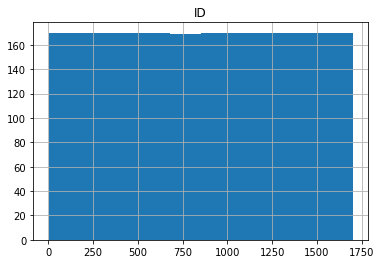

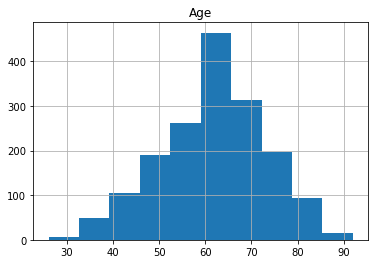

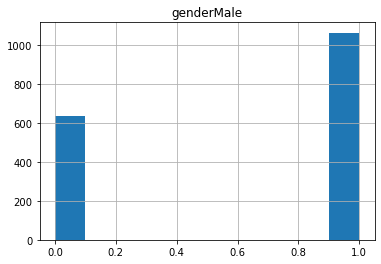

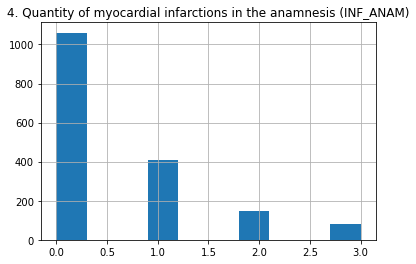

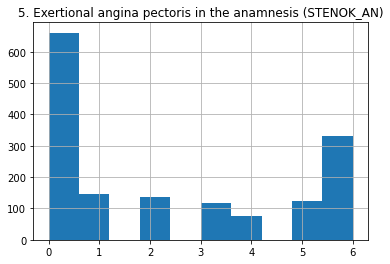

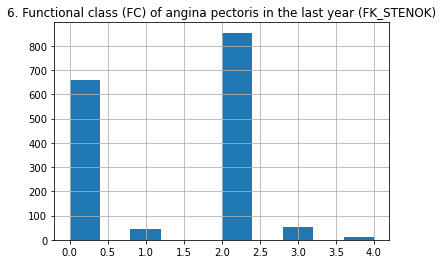

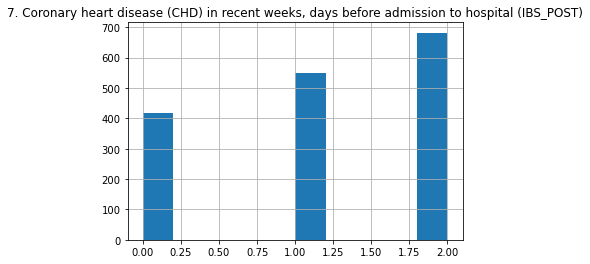

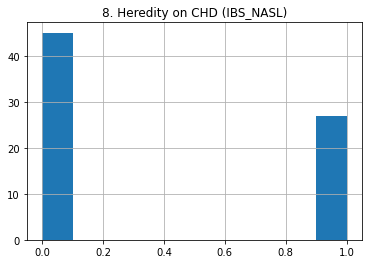

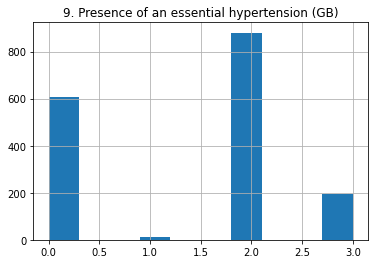

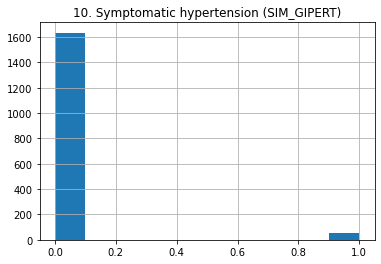

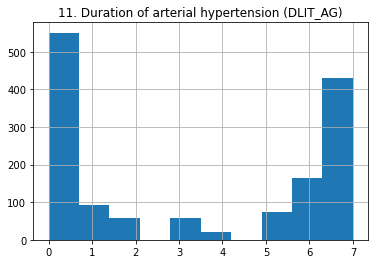

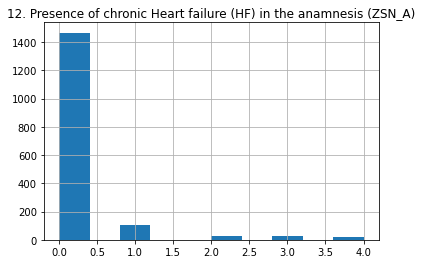

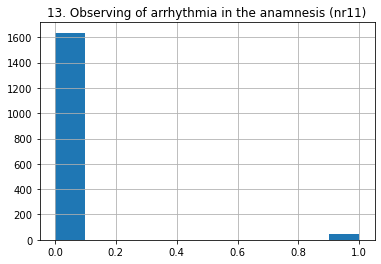

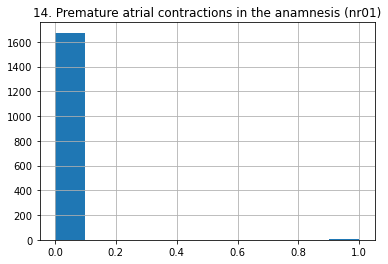

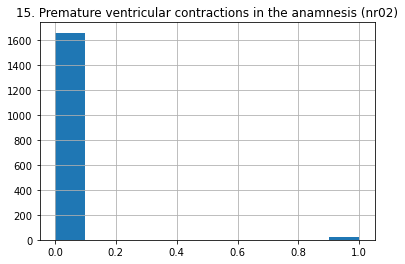

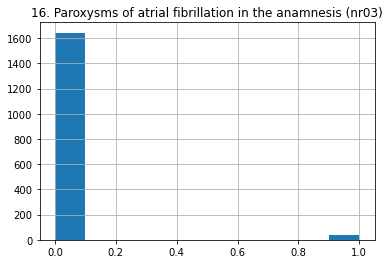

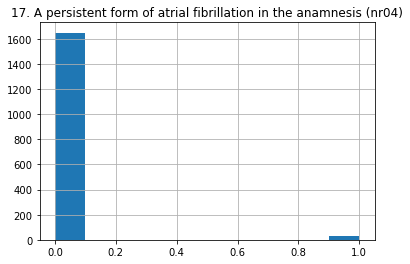

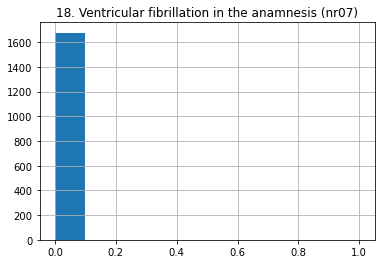

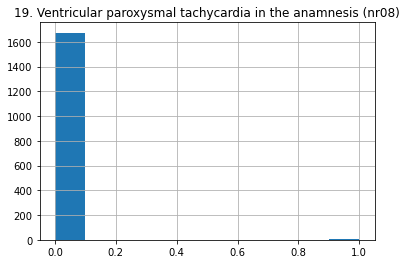

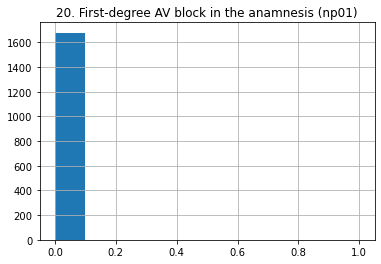

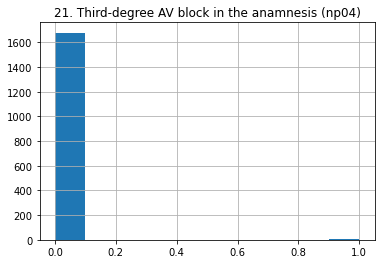

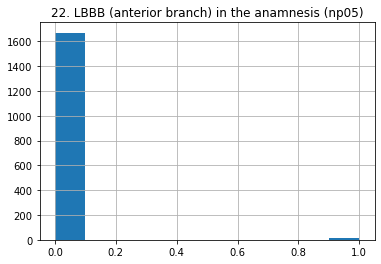

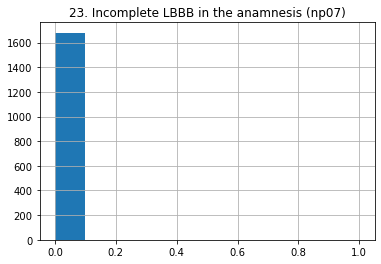

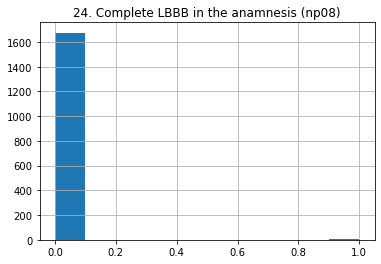

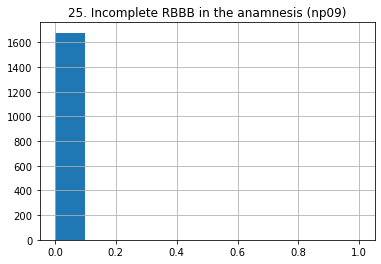

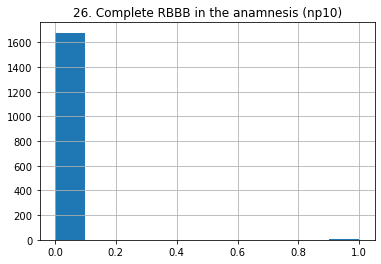

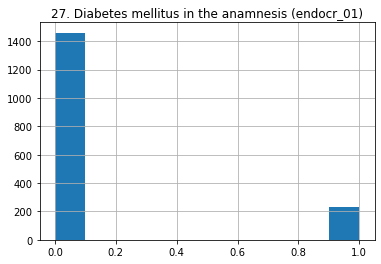

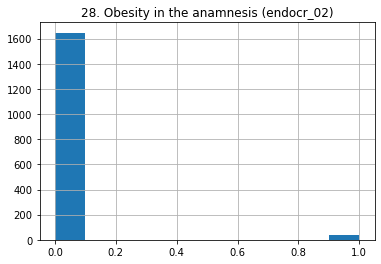

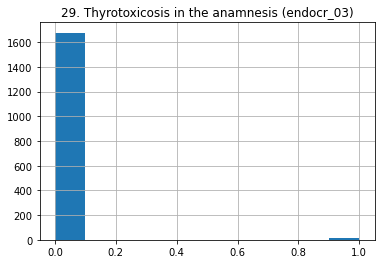

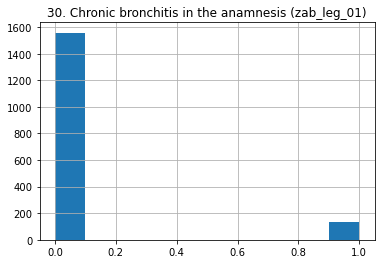

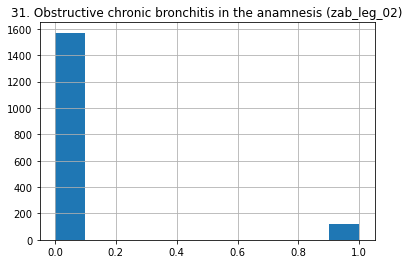

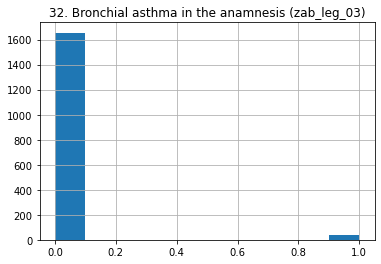

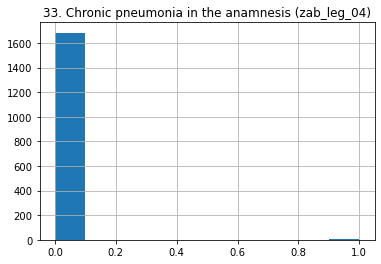

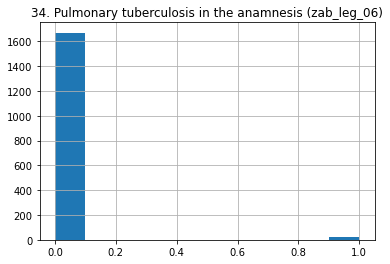

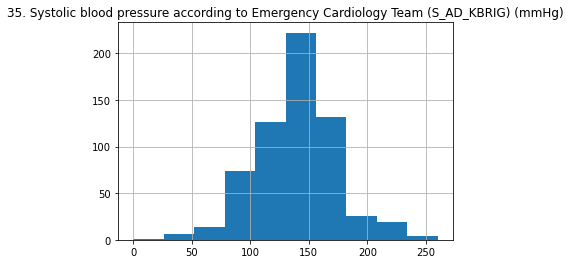

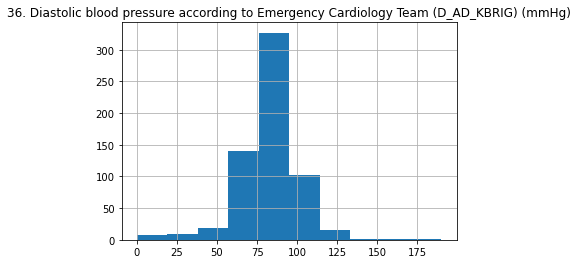

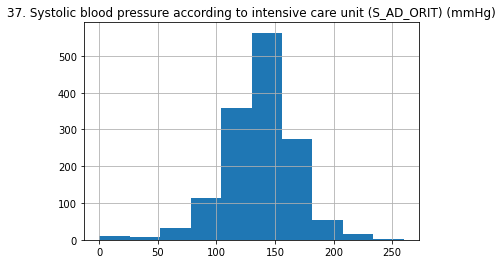

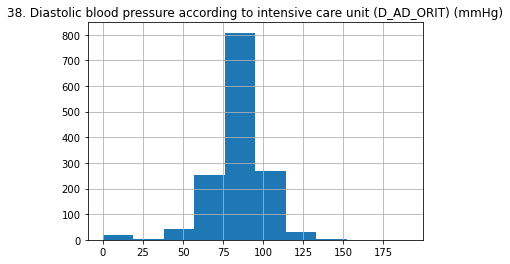

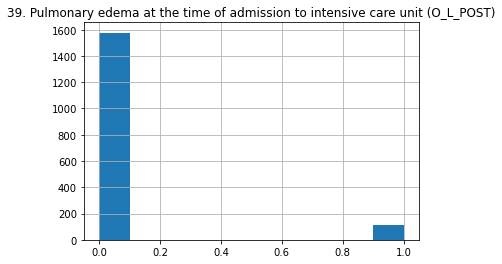

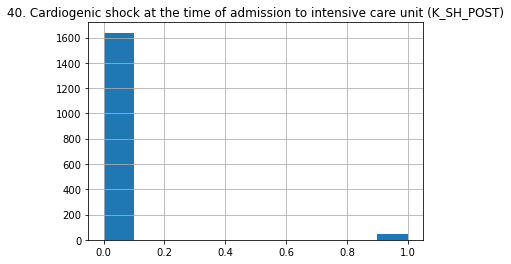

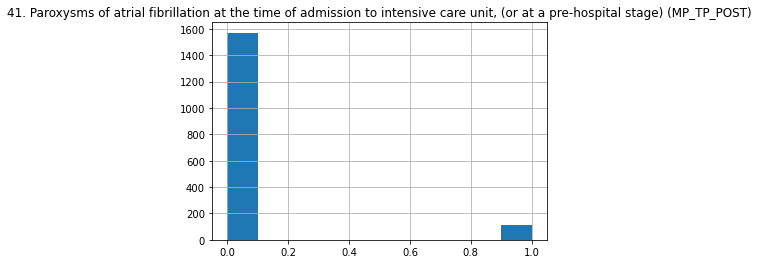

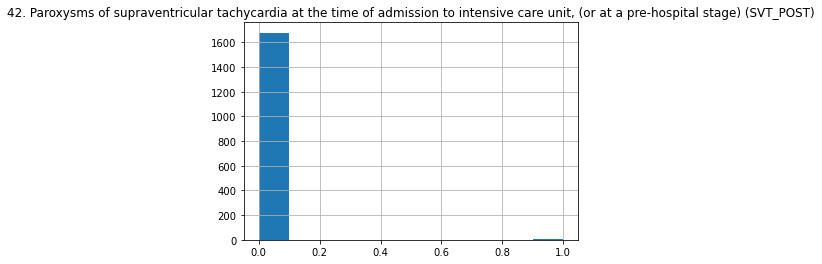

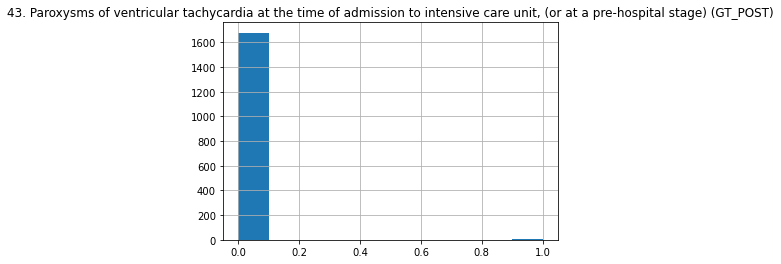

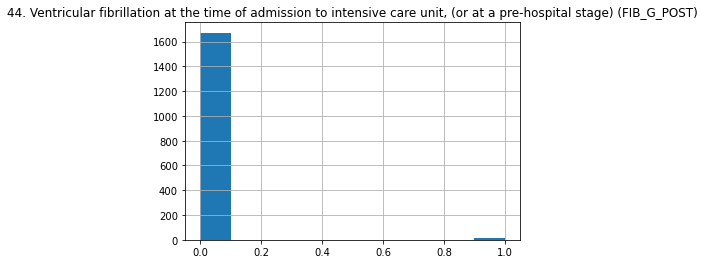

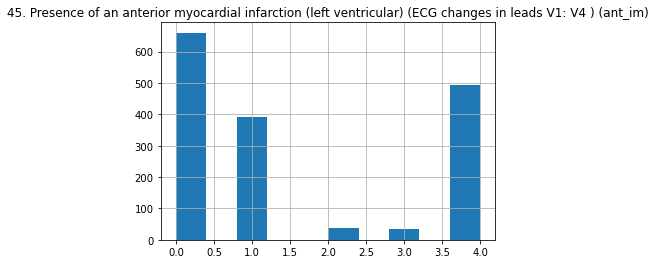

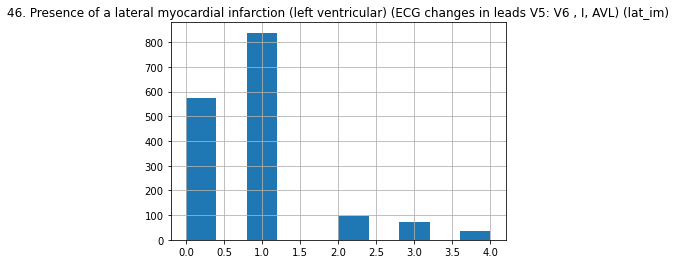

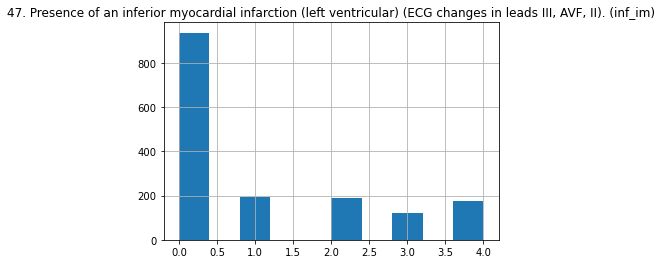

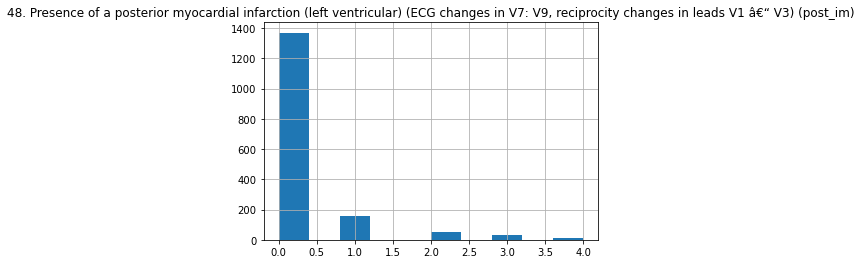

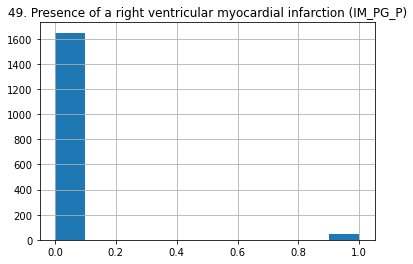

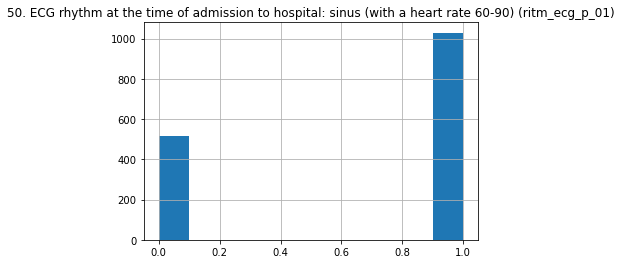

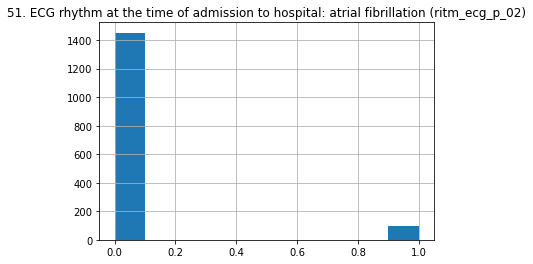

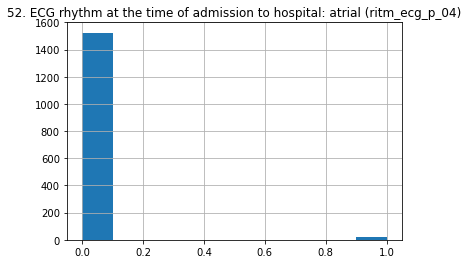

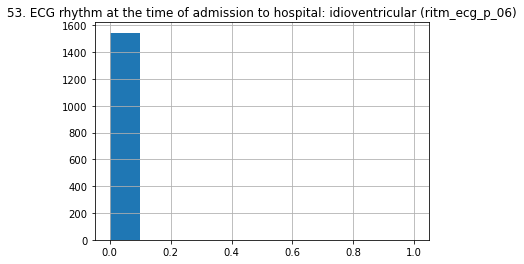

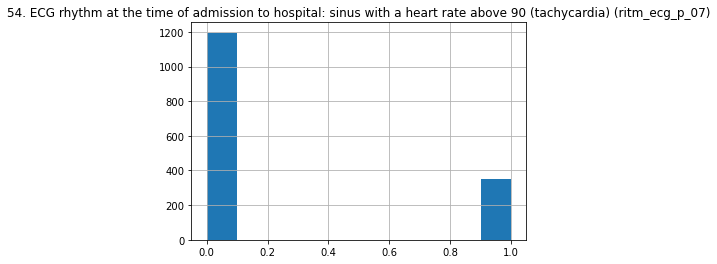

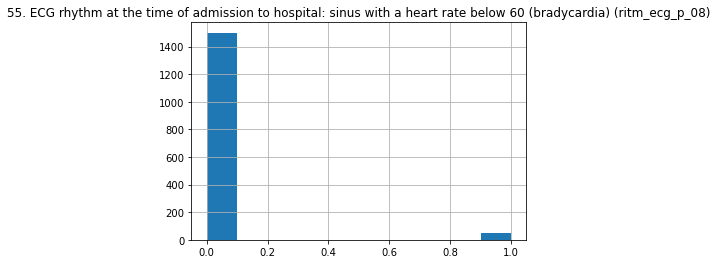

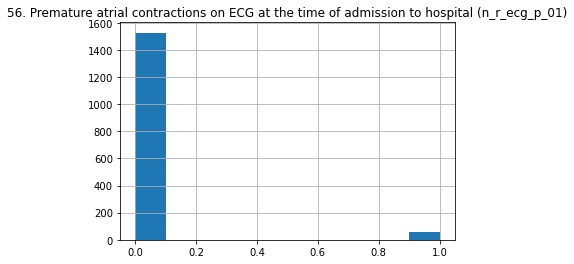

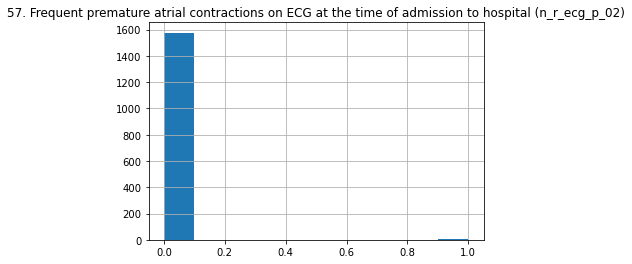

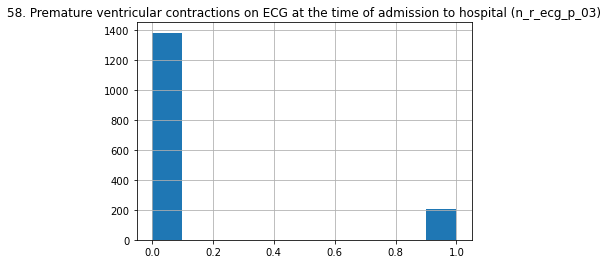

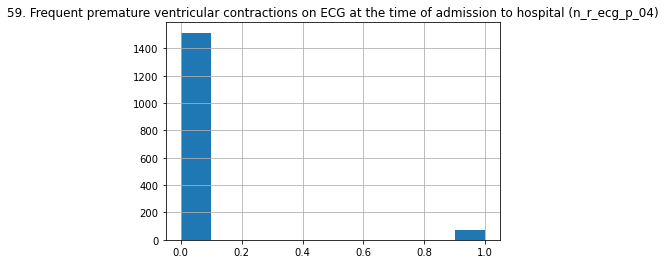

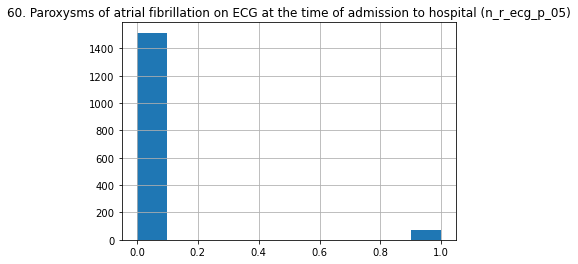

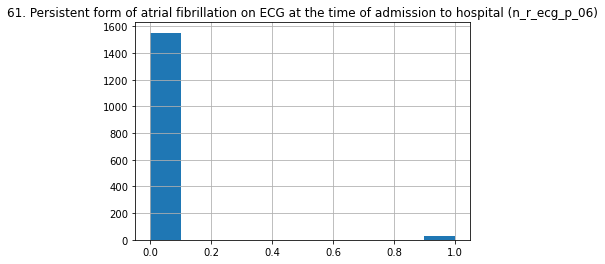

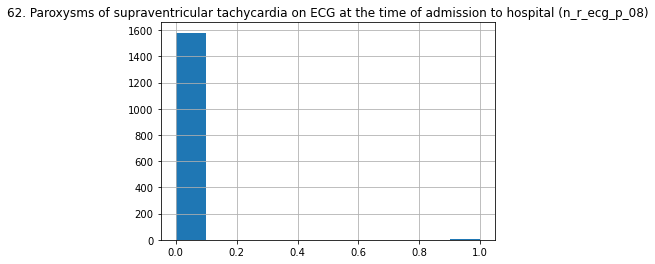

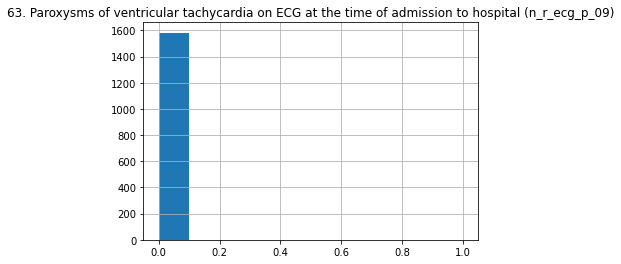

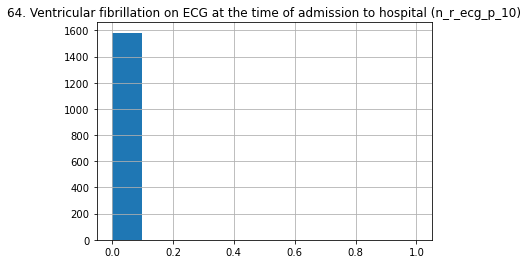

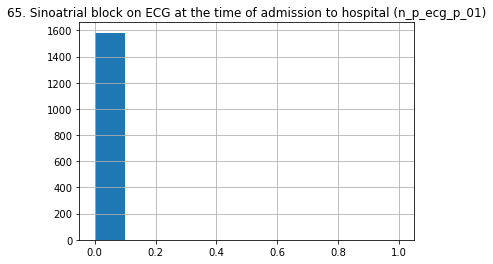

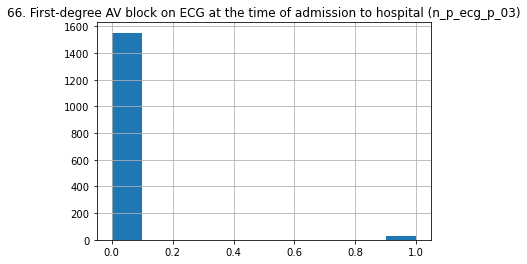

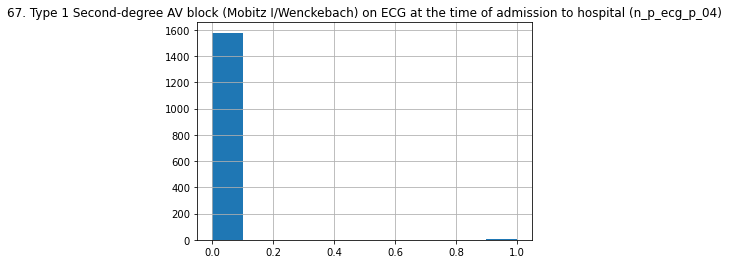

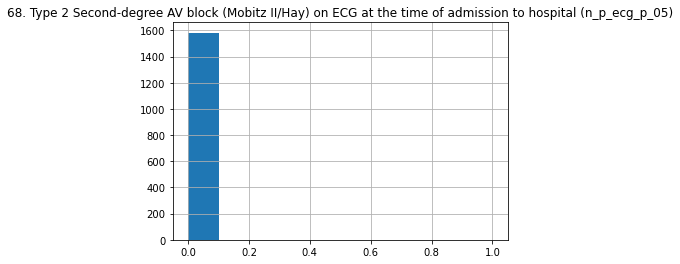

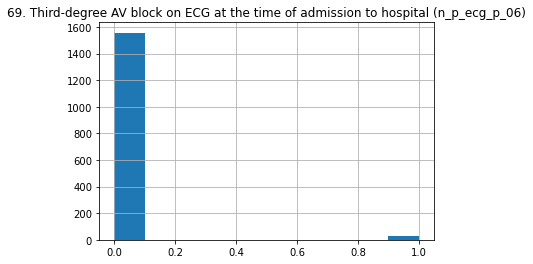

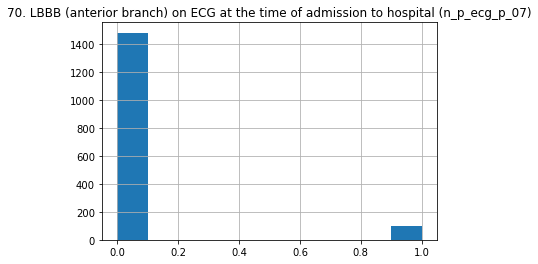

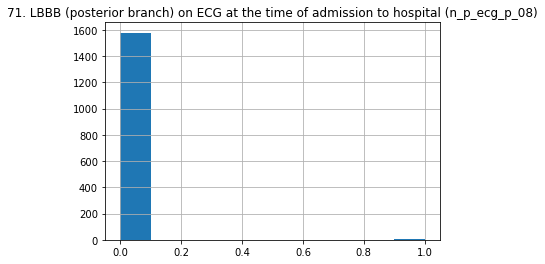

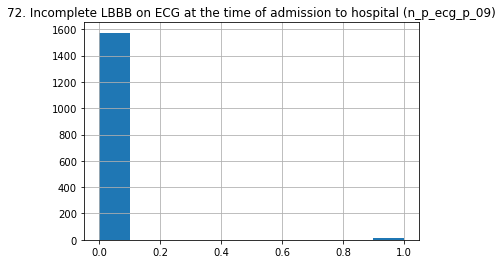

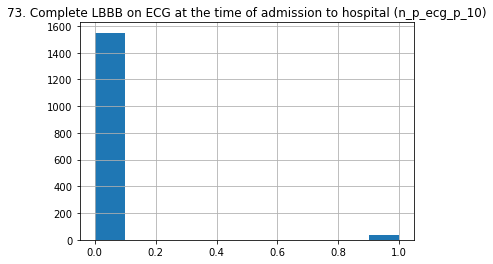

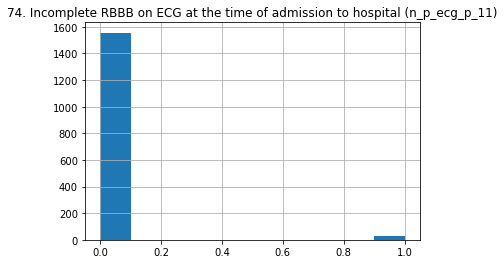

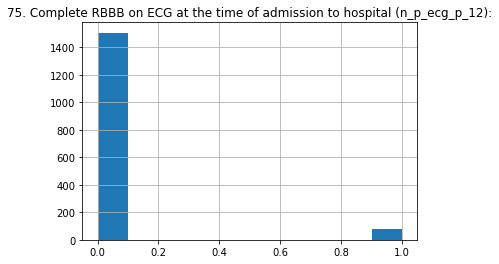

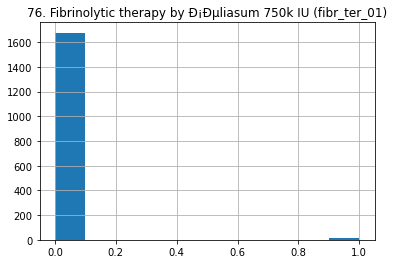

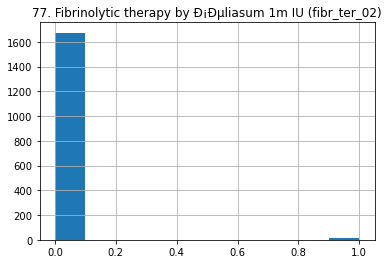

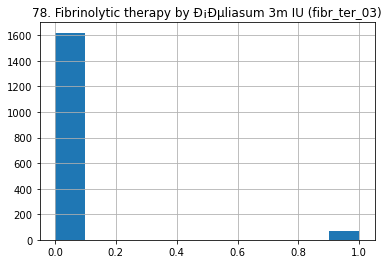

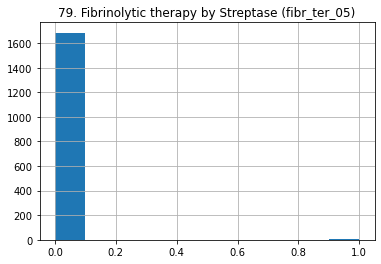

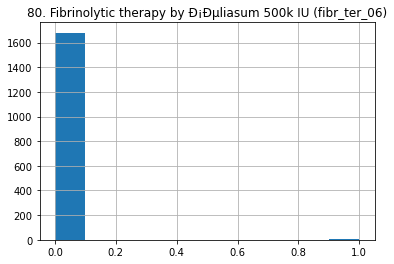

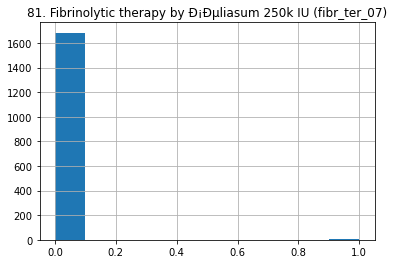

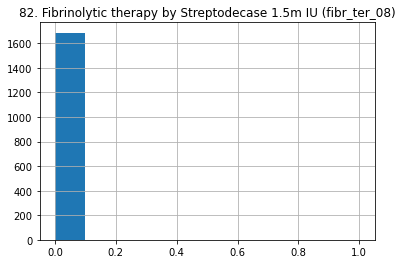

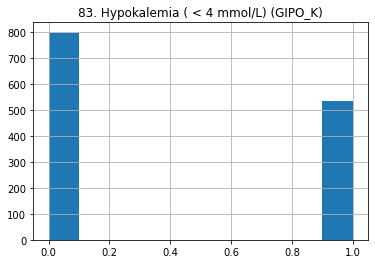

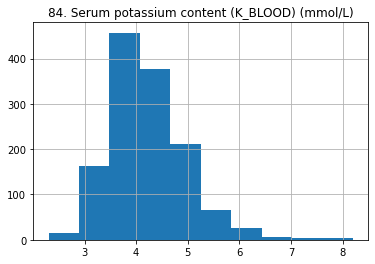

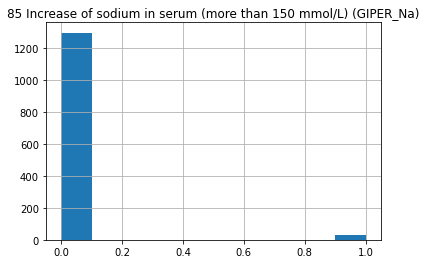

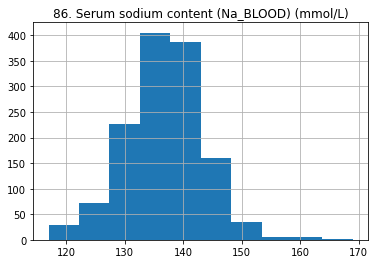

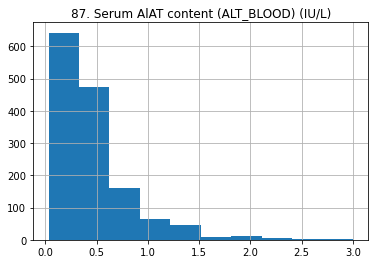

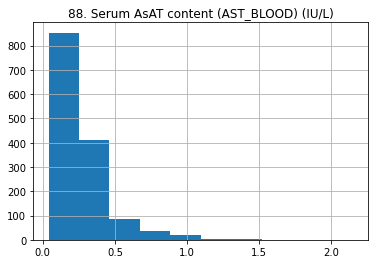

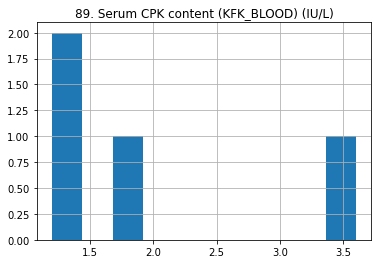

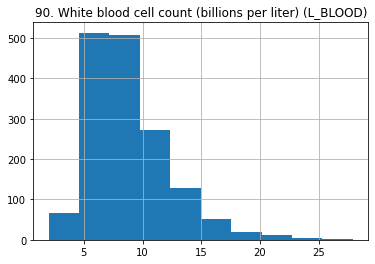

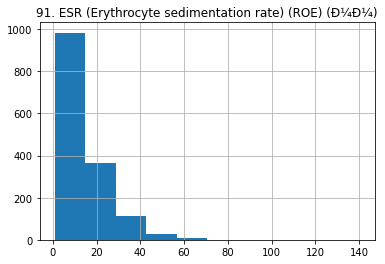

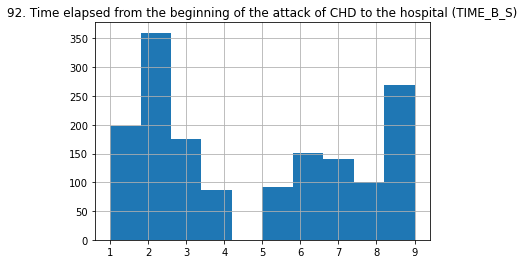

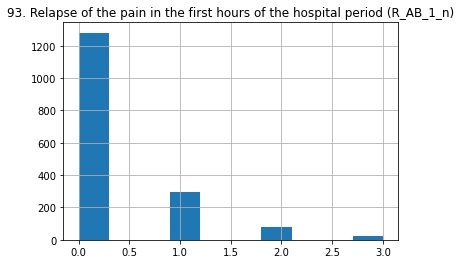

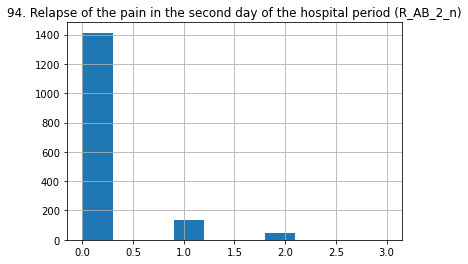

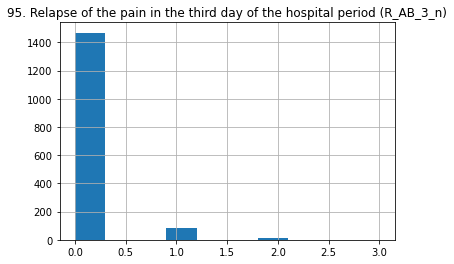

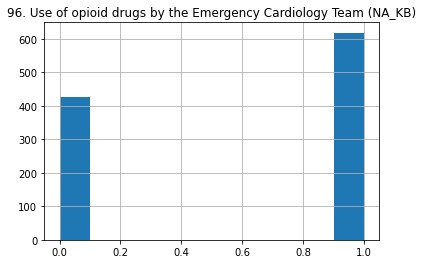

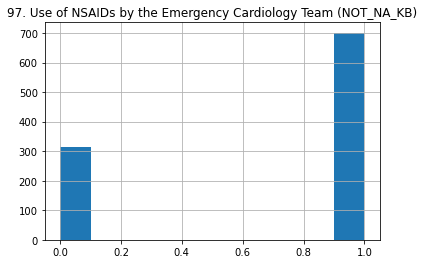

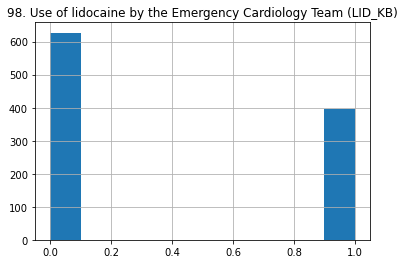

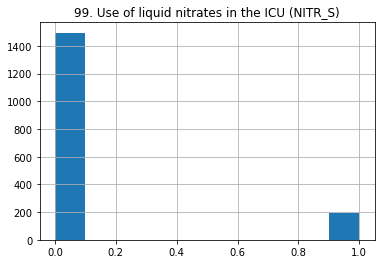

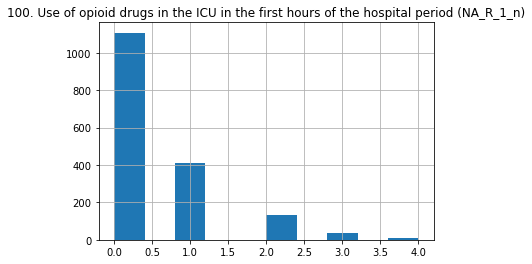

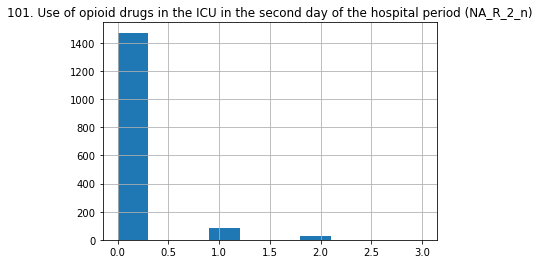

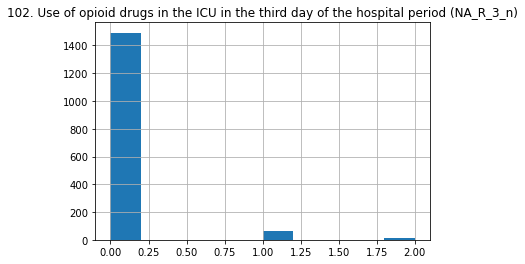

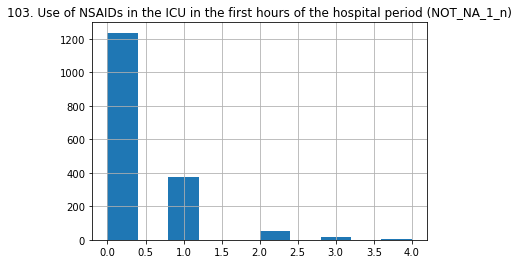

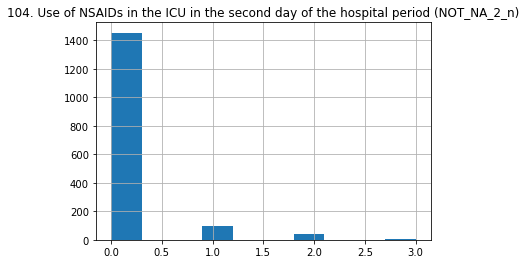

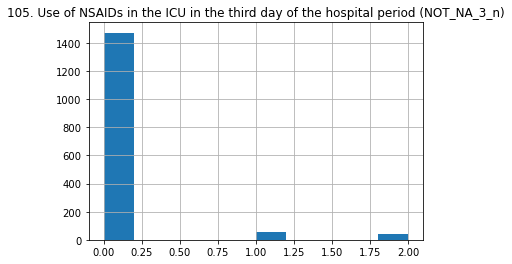

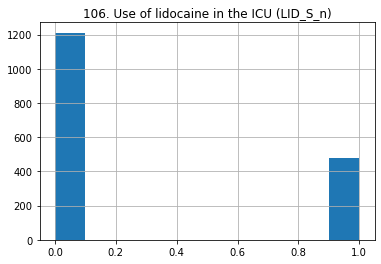

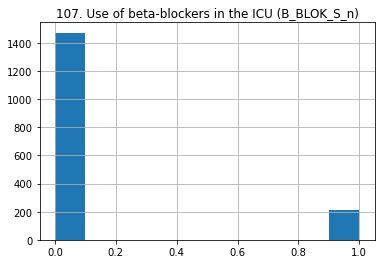

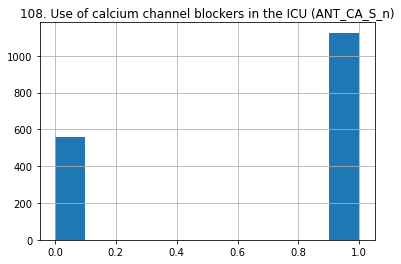

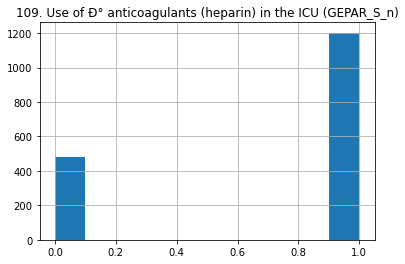

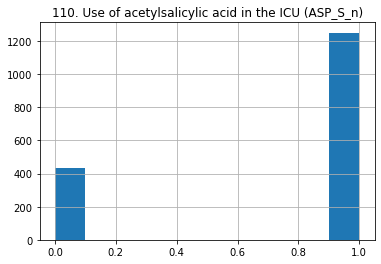

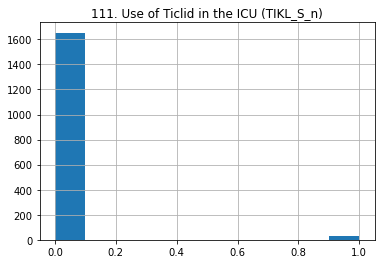

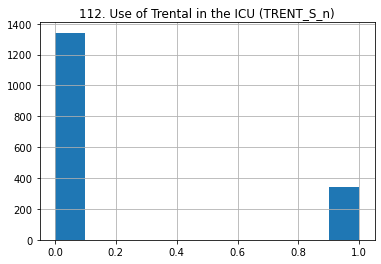

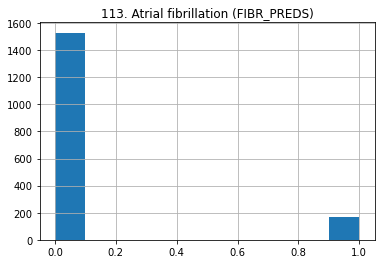

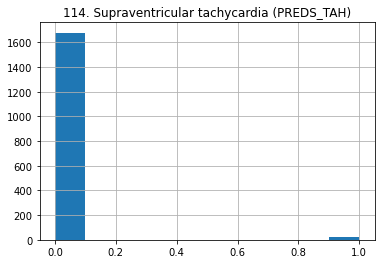

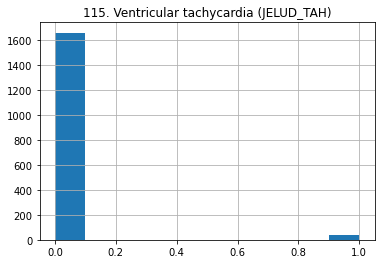

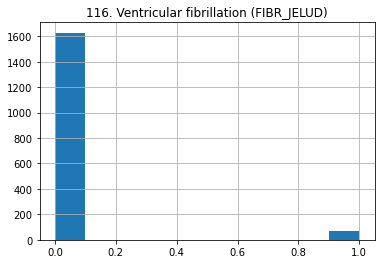

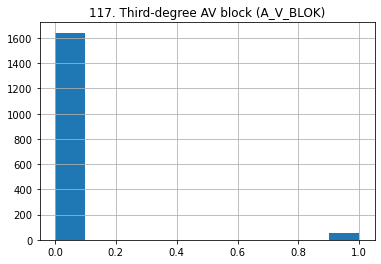

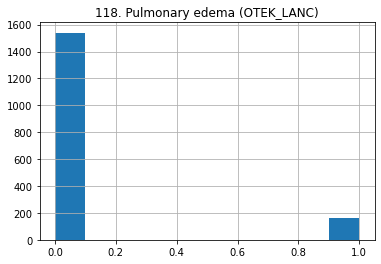

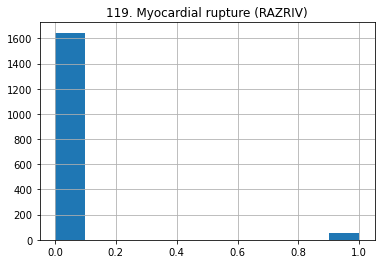

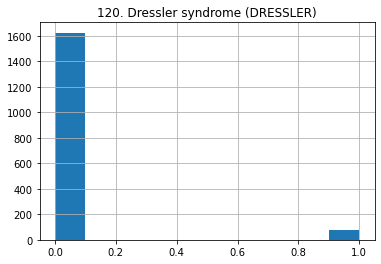

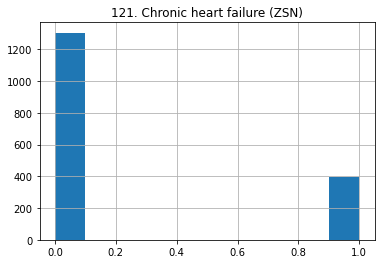

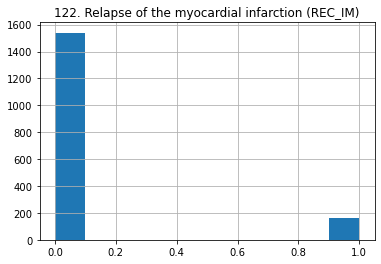

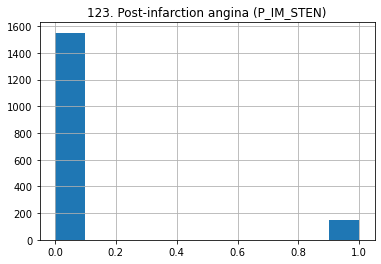

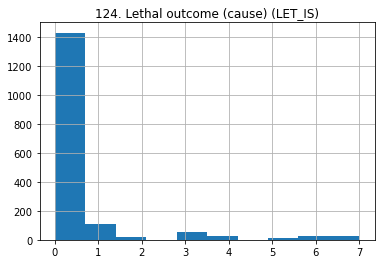

In [180]:
# data.hist(figsize=(24,16))
for column in data.columns:
    data.hist(column=column)

Age looks normally distributed. Gender is slightly more male. The binary variables all look skewed, some with only 0's. The categorical variables also look skewed. The numeric variables mostly look normally distributed. 

## Data Preprocessing
* Drop any columns that are 90% NaN
* Fill remaining NaN with median (not mean since a lot of columns are categorial 0-1 or 0-n)
* Select only first day data
* Separate predictors from outcomes

In [221]:
# print(data)
# data = data.replace("?", np.nan)

cleaned_data = data.dropna(axis=1, how='all', thresh=len(data)*0.9) # Note this removes columns

cleaned_data = cleaned_data.fillna(cleaned_data.median())

not_first_day = ["93. Relapse of the pain in the first hours of the hospital period (R_AB_1_n)",
    "94. Relapse of the pain in the second day of the hospital period (R_AB_2_n)",
    "95. Relapse of the pain in the third day of the hospital period (R_AB_3_n)",
    "100. Use of opioid drugs in the ICU in the first hours of the hospital period (NA_R_1_n)",
    "101. Use of opioid drugs in the ICU in the second day of the hospital period (NA_R_2_n)",
    "102. Use of opioid drugs in the ICU in the third day of the hospital period (NA_R_3_n)",
    "103. Use of NSAIDs in the ICU in the first hours of the hospital period (NOT_NA_1_n)",
    "104. Use of NSAIDs in the ICU in the second day of the hospital period (NOT_NA_2_n)",
    "105. Use of NSAIDs in the ICU in the third day of the hospital period (NOT_NA_3_n)"]

predictors = cleaned_data.iloc[:, 1:-12]
predictors = predictors.drop(not_first_day, axis=1)
outcomes = cleaned_data.iloc[:, -12:]


## Logistic Modeling
* Split into training/testing sets
* Scale data using StandardScaler()
* Run logistic regression on survival and compare accuracy, precision and AOC
* Run logistic repression on all outcomes and compare accuracy, precision and AOC

In [224]:
X_train, X_test, y_train, y_test = train_test_split(predictors, np.where(outcomes['124. Lethal outcome (cause) (LET_IS)'] == 0, 1, 0), test_size=0.20, random_state=42)
# pipe = make_pipeline([('scl', StandardScaler()), ('log', LogisticRegression())])
# pipe.fit(X_train, y_train)
from sklearn.pipeline import Pipeline
pipe_log = Pipeline([('scl', StandardScaler()),
                    ('log', LogisticRegression())])
pipe_log.fit(X_train, y_train)

# Accuracy and precision
print("Survival")
print(f"Accuracy: {pipe_log.score(X_test, y_test):.3f}")
print(f"Precision: {precision_score(y_test, pipe_log.predict(X_test)):.3f}")

# ROC AOC
y_train_pred = pipe_log.predict_proba(X_train)[:,1]
y_test_pred = pipe_log.predict_proba(X_test)[:,1]
# print(f"AUC Train: {roc_auc_score(y_train, y_train_pred):.4f}")
print(f"AUC Test: {roc_auc_score(y_test, y_test_pred):.4f}")

for outcome in outcomes.columns[:-1]:
    X_train, X_test, y_train, y_test = train_test_split(predictors, outcomes[outcome].astype(int), test_size=0.20, random_state=42)
    pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
    pipe.fit(X_train, y_train)
    # Accuracy and precision
    print(outcome)
    print(f"Accuracy: {pipe.score(X_test, y_test):.3f}")
    print(f"Precision: {precision_score(y_test, pipe.predict(X_test), zero_division=1):.3f}")
    # ROC AOC
    y_train_pred = pipe.predict_proba(X_train)[:,1]
    y_test_pred = pipe.predict_proba(X_test)[:,1]
    # print(f"AUC Train: {roc_auc_score(y_train, y_train_pred):.4f}")
    print(f"AUC Test: {roc_auc_score(y_test, y_test_pred):.4f}")

Survival
Accuracy: 0.879
Precision: 0.910
AUC Test: 0.8654
113. Atrial fibrillation (FIBR_PREDS)
Accuracy: 0.871
Precision: 0.250
AUC Test: 0.6913
114. Supraventricular tachycardia (PREDS_TAH)
Accuracy: 0.985
Precision: 1.000
AUC Test: 0.6322
115. Ventricular tachycardia (JELUD_TAH)
Accuracy: 0.971
Precision: 1.000
AUC Test: 0.7885
116. Ventricular fibrillation (FIBR_JELUD)
Accuracy: 0.953
Precision: 0.400
AUC Test: 0.6724
117. Third-degree AV block (A_V_BLOK)
Accuracy: 0.959
Precision: 0.167
AUC Test: 0.7773
118. Pulmonary edema (OTEK_LANC)
Accuracy: 0.915
Precision: 0.286
AUC Test: 0.6941
119. Myocardial rupture (RAZRIV)
Accuracy: 0.965
Precision: 0.000
AUC Test: 0.8823
120. Dressler syndrome (DRESSLER)
Accuracy: 0.956
Precision: 1.000
AUC Test: 0.6804
121. Chronic heart failure (ZSN)
Accuracy: 0.744
Precision: 0.400
AUC Test: 0.6118
122. Relapse of the myocardial infarction (REC_IM)
Accuracy: 0.912
Precision: 0.250
AUC Test: 0.6597
123. Post-infarction angina (P_IM_STEN)
Accuracy: 0

For predicting survival, we get a ROC AUC of 0.8654. For the other outcomes, the ROC AUC ranges from 0.6118 to 0.8823. This might be due to the classes being imbalanced. 

Let's look at the coefficients of the logistic regression

In [225]:
odds = np.exp(pipe_log.named_steps['log'].coef_)

pd.DataFrame(odds[0], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
108. Use of calcium channel blockers in the ICU (ANT_CA_S_n),1.520509
92. Time elapsed from the beginning of the attack of CHD to the hospital (TIME_B_S),1.473294
34. Pulmonary tuberculosis in the anamnesis (zab_leg_06),1.469909
13. Observing of arrhythmia in the anamnesis (nr11),1.450101
110. Use of acetylsalicylic acid in the ICU (ASP_S_n),1.412543
...,...
67. Type 1 Second-degree AV block (Mobitz I/Wenckebach) on ECG at the time of admission to hospital (n_p_ecg_p_04),0.697041
45. Presence of an anterior myocardial infarction (left ventricular) (ECG changes in leads V1: V4 ) (ant_im),0.665423
54. ECG rhythm at the time of admission to hospital: sinus with a heart rate above 90 (tachycardia) (ritm_ecg_p_07),0.638743
40. Cardiogenic shock at the time of admission to intensive care unit (K_SH_POST),0.614608


In [207]:
1/0.567818

1.761127685279438

Age was the biggest predictor of outcome (since 1/0.567818 is 1.76, which is the multiplicative effect of a 1-unit increase of age on the odds of not being a survivor).

## XGBoost Modeling
* Create XGBoost classifier with random hyperparameters

In [213]:
X_train, X_test, y_train, y_test = train_test_split(predictors, np.where(outcomes['124. Lethal outcome (cause) (LET_IS)'] == 0, 1, 0), test_size=0.20, random_state=42)
model_xgboost = xgboost.XGBClassifier(learning_rate=0.1,
                                      max_depth=5,
                                      n_estimators=5000,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      eval_metric='auc',
                                      early_stopping_rounds=10,
                                      verbosity=1)

eval_set = [(X_test, y_test)]

model_xgboost.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.72332
[1]	validation_0-auc:0.79731
[2]	validation_0-auc:0.82963
[3]	validation_0-auc:0.83076
[4]	validation_0-auc:0.83604
[5]	validation_0-auc:0.83741
[6]	validation_0-auc:0.82395
[7]	validation_0-auc:0.83864
[8]	validation_0-auc:0.85537
[9]	validation_0-auc:0.85176
[10]	validation_0-auc:0.86111
[11]	validation_0-auc:0.85998
[12]	validation_0-auc:0.87260
[13]	validation_0-auc:0.86879
[14]	validation_0-auc:0.87153
[15]	validation_0-auc:0.87373
[16]	validation_0-auc:0.87894
[17]	validation_0-auc:0.87547
[18]	validation_0-auc:0.87507
[19]	validation_0-auc:0.87680
[20]	validation_0-auc:0.87607
[21]	validation_0-auc:0.87667
[22]	validation_0-auc:0.87874
[23]	validation_0-auc:0.88508
[24]	validation_0-auc:0.88268
[25]	validation_0-auc:0.88128
[26]	validation_0-auc:0.88488
[27]	validation_0-auc:0.88669
[28]	validation_0-auc:0.88194
[29]	validation_0-auc:0.88401
[30]	validation_0-auc:0.88502
[31]	validation_0-auc:0.88341
[32]	validation_0-auc:0.88415
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=5000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

## XGBoost Hyperparameter Tuning
* Use grid search CV to fine tune hyperparameters

In [168]:
learning_rates = [0.02, 0.05, 0.1]
max_depths = [2, 3, 5]
n_estimators = [1000, 2000, 5000]

params_dict = {"learning_rate": learning_rates,
               "max_depth": max_depths,
               "n_estimators": n_estimators}

In [169]:
def calc_roc_auc_score(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:,1])

model_xgboost_hp = GridSearchCV(estimator=xgboost.XGBClassifier(
    subsample=0.5,
    colsample_bytree=0.25,
    eval_metric='auc',
    use_label_encoder=False),
    param_grid=params_dict,
    cv=2,
    scoring=calc_roc_auc_score,
    return_train_score=True,
    verbose=4)


model_xgboost_hp.fit(predictors, np.where(outcomes['124. Lethal outcome (cause) (LET_IS)'] == 0, 1, 0))


Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=1000;, score=(train=0.961, test=0.832) total time=   0.4s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=1000;, score=(train=0.958, test=0.845) total time=   0.3s
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=2000;, score=(train=0.978, test=0.827) total time=   0.9s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=2000;, score=(train=0.981, test=0.839) total time=   0.8s
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=5000;, score=(train=0.996, test=0.811) total time=   2.1s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=5000;, score=(train=0.998, test=0.837) total time=   2.1s
[CV 1/2] END learning_rate=0.02, max_depth=3, n_estimators=1000;, score=(train=0.982, test=0.829) total time=   0.4s
[CV 2/2] END learning_rate=0.02, max_depth=3, n_estimators=1000;, score=(train=0.985, test=0.851) total time=   0.4s
[CV

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.25,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

Show best parameter combinations

In [170]:
df_cv_results = pd.DataFrame(model_xgboost_hp.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
df_cv_results.sort_values(by='rank_test_score', inplace=True)
df_cv_results

,rank_test_score,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators
3,1,0.839988,0.983432,0.02,3,1000
6,2,0.838890,0.998266,0.02,5,1000
0,3,0.838587,0.959561,0.02,2,1000
4,4,0.833406,0.996761,0.02,3,2000
1,5,0.832838,0.979678,0.02,2,2000
7,6,0.831890,0.999979,0.02,5,2000
12,7,0.830460,0.998665,0.05,3,1000
9,8,0.827127,0.985189,0.05,2,1000
2,9,0.824090,0.996922,0.02,2,5000
13,10,0.822724,0.999995,0.05,3,2000


The best parameters were learning_rate = 0.02, max_depth = 3 and n_estimators = 1000.

Create final model with these parameters

In [214]:
model_xgboost_final = xgboost.XGBClassifier(learning_rate=0.02,
                                      max_depth=3,
                                      n_estimators=1000,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      eval_metric='auc',
                                      verbosity=0,
                                      use_label_encoder=False,
                                      early_stopping_rounds=20)
eval_set = [(X_train, y_train),(X_test, y_test)]

model_xgboost_final.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.68625	validation_1-auc:0.70800
[1]	validation_0-auc:0.76303	validation_1-auc:0.79056
[2]	validation_0-auc:0.80100	validation_1-auc:0.79764
[3]	validation_0-auc:0.80532	validation_1-auc:0.80542
[4]	validation_0-auc:0.80132	validation_1-auc:0.81177
[5]	validation_0-auc:0.80979	validation_1-auc:0.80409
[6]	validation_0-auc:0.80745	validation_1-auc:0.78746
[7]	validation_0-auc:0.81497	validation_1-auc:0.80722
[8]	validation_0-auc:0.82309	validation_1-auc:0.82656
[9]	validation_0-auc:0.82435	validation_1-auc:0.81524
[10]	validation_0-auc:0.82496	validation_1-auc:0.80956
[11]	validation_0-auc:0.84070	validation_1-auc:0.81737
[12]	validation_0-auc:0.84722	validation_1-auc:0.81604
[13]	validation_0-auc:0.84668	validation_1-auc:0.81611
[14]	validation_0-auc:0.84792	validation_1-auc:0.82078
[15]	validation_0-auc:0.85053	validation_1-auc:0.82485
[16]	validation_0-auc:0.85391	validation_1-auc:0.82823
[17]	validation_0-auc:0.85816	validation_1-auc:0.82409
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=20, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [215]:
# ROC AOC
y_train_pred = model_xgboost_final.predict_proba(X_train)[:,1]
y_test_pred = model_xgboost_final.predict_proba(X_test)[:,1]
print(f"AUC Train: {roc_auc_score(y_train, y_train_pred):.4f}")
print(f"AUC Test: {roc_auc_score(y_test, y_test_pred):.4f}")

AUC Train: 0.9048
AUC Test: 0.8808


The AUC for the training data (0.8808) is slightly better than the logistic regression (0.8654). 

Let's check feature importance

In [182]:
df_feature_imp = pd.DataFrame({"Variable": predictors.columns,
                           "Importance": model_xgboost.feature_importances_}) \
                        .sort_values(by='Importance', ascending=False)
df_feature_imp[:20]

,Variable,Importance
32,40. Cardiogenic shock at the time of admission...,0.074973
42,50. ECG rhythm at the time of admission to hos...,0.046920
67,75. Complete RBBB on ECG at the time of admiss...,0.040055
8,12. Presence of chronic Heart failure (HF) in ...,0.035729
58,66. First-degree AV block on ECG at the time o...,0.032219
80,108. Use of calcium channel blockers in the IC...,0.028720
77,99. Use of liquid nitrates in the ICU (NITR_S),0.028364
31,39. Pulmonary edema at the time of admission t...,0.028356
24,28. Obesity in the anamnesis (endocr_02),0.028260
43,51. ECG rhythm at the time of admission to hos...,0.027032


## Conclusion
Logistic regression and XGBoost were used to classify survival for ER patients with myocardial infarctions. They both performed pretty well, with an area under the ROC curve of 0.8654 and 0.8808 respectively. For the logistic regression model, the age variable had the largest effect on survival. For the XGBoost model, cardiogenic shock at the time of admission was the most predictive feature for XGBoost. 